## PROJET DE FILTRAGE ANTI-SPAM

Le dataset utilisé est disponible via le lien : https://www.kaggle.com/datasets/abdallahwagih/spam-emails. 
A partir de ce dataset, plusieurs **modèles de classification** ont été développé et un seul a été retenu pour prédire si un mail reçu serait classé **spam** ou **ham**. Les différents modèles de ML estimé, ont été choisi parmi ceux qu'offraient la littérature disponible à cet effet. Il s'agit des modèles suivants :
    - (Support VEector Machine)
    - Classification Naive de Bayes (Bernoulli, Gaussien et Multinomial)
    - Logit binaire
    - Arbre de décision
    - Random Forest 
A partir du présent notebook une sérialisation a été effectué. Les fichiers ".pkl" obtenu à la fin contient le modèle de ML retenu. Ce fichier sera utilisé dans le sript Python qui sera conçu pour le déploiement du modèle dans une interface Streamlit.

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
nltk.download('stopwords')
nltk.download('punkt')
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
import spacy
import wordcloud  

[nltk_data] Downloading package stopwords to C:\Users\hp ProBook 450
[nltk_data]     G8\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\hp ProBook 450
[nltk_data]     G8\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Importation du dataset

In [43]:
data = pd.read_csv("C:/Users/hp ProBook 450 G8/Documents/PROGRAMME ISE/ISE 2/SEMESTRE 3/MACHINE LEARNING 1/PROJET/spam.csv", encoding=('ISO-8859-1'),low_memory=False)
data.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [44]:
# Dimension du dataset

data.shape

(5574, 2)

# Nettoyage de la base de données

In [45]:
# Type de variables

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5574 entries, 0 to 5573
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   5574 non-null   object
 1   text    5574 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [46]:
# Relabélisation des colonnes

data.rename(columns={'label':'Target', 'text':'Text'}, inplace=True)
data.head()

,Target,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [47]:
# Encodage de la target

from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
data['Target'] = encoder.fit_transform(data['Target'])
data.head()

,Target,Text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [48]:
# Valeurs manquantes

data.isnull().sum()

Target    0
Text      0
dtype: int64

In [49]:
# Vérification des doublons

print(data.duplicated().sum())

403


In [50]:
# Suppression des doublons

data = data.drop_duplicates(keep='first')
print(data.duplicated().sum())

0


In [51]:
# Dimension du dataset

data.shape

(5171, 2)

# ANALYSE EXPLORATOIRE DES DONNEES

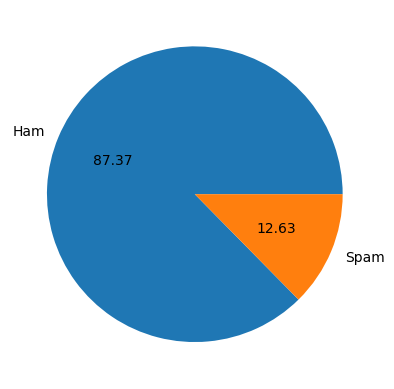

In [52]:
# Visualisation de la Target

plt.pie(data['Target'].value_counts(), labels=['Ham', 'Spam'],autopct="%0.2f")
plt.show()

In [53]:
# Ajout de la variable "Nbre_Charact" (Nombre de charactères)

data['Nbre_Charact'] = data['Text'].apply(len)

# Ajout de la variable "Nbre_Mots" (Nombre de mots)
import spacy
nlp = spacy.load("en_core_web_sm")
data['Nbre_Mots'] = data['Text'].apply(lambda x: len([token.text for token in nlp(x) if not token.is_punct and not token.is_space]))

In [54]:
data.head()

,Target,Text,Nbre_Charact,Nbre_Mots
0,0,"Go until jurong point, crazy.. Available only ...",111,20
1,0,Ok lar... Joking wif u oni...,29,6
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,30
3,0,U dun say so early hor... U c already then say...,49,11
4,0,"Nah I don't think he goes to usf, he lives aro...",61,14


In [55]:
# Ajout de la variable "Nbre_Phrases" (Nombre de phrases)

data['Nbre_Phrases'] = data['Text'].apply(lambda x: len(list(nlp(x).sents)))

In [56]:
data.head()

,Target,Text,Nbre_Charact,Nbre_Mots,Nbre_Phrases
0,0,"Go until jurong point, crazy.. Available only ...",111,20,3
1,0,Ok lar... Joking wif u oni...,29,6,2
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,30,2
3,0,U dun say so early hor... U c already then say...,49,11,2
4,0,"Nah I don't think he goes to usf, he lives aro...",61,14,1


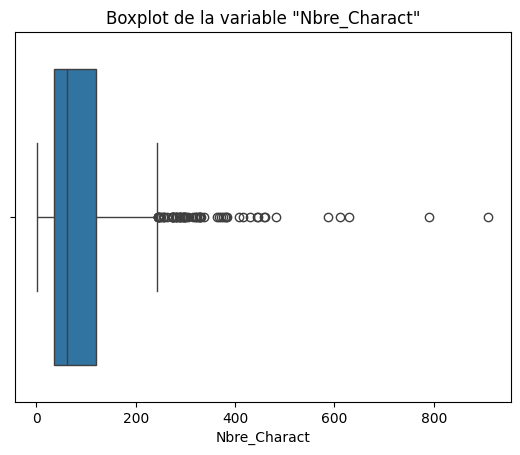

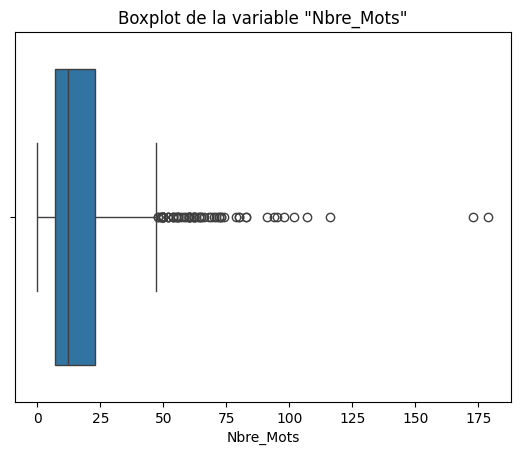

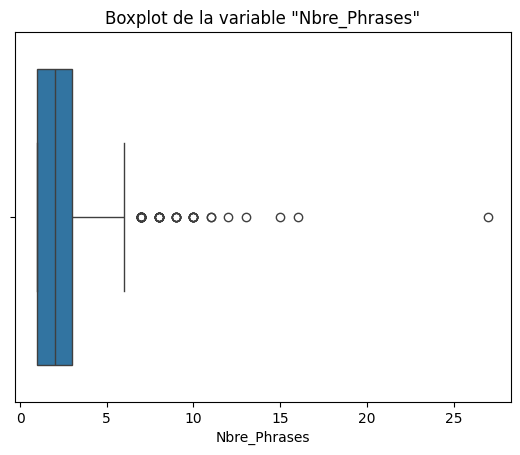

In [57]:
# Boxplot pour chacune des variables numériques

for col in ['Nbre_Charact', 'Nbre_Mots', 'Nbre_Phrases']:
    sns.boxplot(x=data[col])
    plt.title(f'Boxplot de la variable "{col}"')
    plt.show()

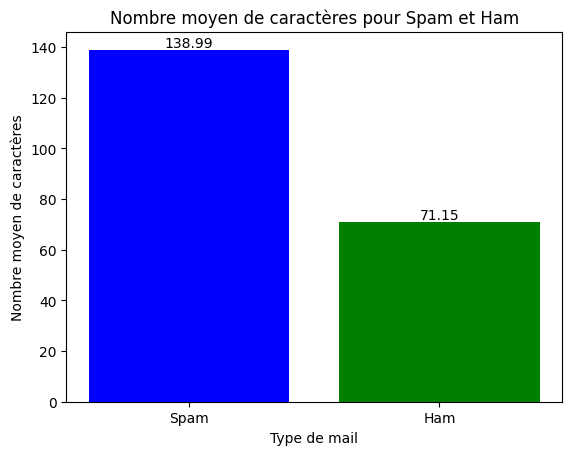

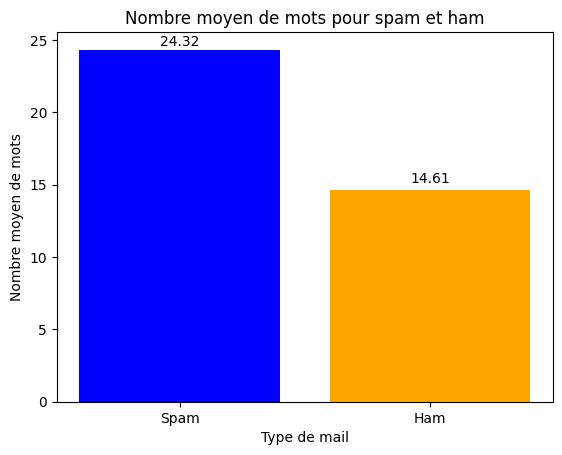

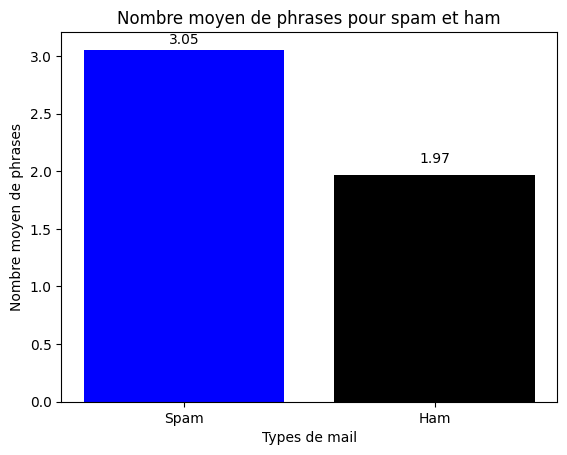

In [58]:
# Nombre moyen de caractères pour spam et ham

avg_length_spam = data[data['Target'] == 1]['Nbre_Charact'].mean()
avg_length_ham = data[data['Target'] == 0]['Nbre_Charact'].mean()
plt.text(0, avg_length_spam + 1, round(avg_length_spam, 2), ha='center', color='black')  
plt.text(1, avg_length_ham + 1, round(avg_length_ham, 2), ha='center', color='black') 
plt.bar(['Spam', 'Ham'], [avg_length_spam, avg_length_ham], color=['Blue', 'green'])
plt.title('Nombre moyen de caractères pour Spam et Ham')
plt.xlabel('Type de mail')
plt.ylabel('Nombre moyen de caractères')
plt.show()

# Nombre moyen de mots pour spam et ham 

avg_word_spam = data[data['Target'] == 1]['Nbre_Mots'].mean()
avg_word_ham = data[data['Target'] == 0]['Nbre_Mots'].mean()
plt.text(0, avg_word_spam + 0.3, round(avg_word_spam, 2), ha='center', color='black')  
plt.text(1, avg_word_ham + 0.5, round(avg_word_ham, 2), ha='center', color='black')
# Plotting the graph
plt.bar(['Spam', 'Ham'], [avg_word_spam, avg_word_ham], color=['Blue', 'orange'])
plt.title('Nombre moyen de mots pour spam et ham')
plt.xlabel('Type de mail')
plt.ylabel('Nombre moyen de mots')
plt.show()

# Nombre moyen de phrases pour spam et ham

avg_sentence_spam = data[data['Target'] == 1]['Nbre_Phrases'].mean()
avg_sentence_ham = data[data['Target'] == 0]['Nbre_Phrases'].mean()
plt.text(0, avg_sentence_spam + 0.05, round(avg_sentence_spam, 2), ha='center', color='black')  
plt.text(1, avg_sentence_ham + 0.1, round(avg_sentence_ham, 2), ha='center', color='black')
# Plotting the graph
plt.bar(['Spam', 'Ham'], [avg_sentence_spam, avg_sentence_ham], color=['Blue', 'black'])
plt.title('Nombre moyen de phrases pour spam et ham')
plt.xlabel('Types de mail')
plt.ylabel('Nombre moyen de phrases')
plt.show()

In [59]:
# Statistique bivariée

# Calcul des statistiques de test de Kruskal-Wallis et des p-valeurs pour chaque variable numérique
num_vars = ['Nbre_Charact', 'Nbre_Mots', 'Nbre_Phrases']

from scipy.stats import kruskal
p_values = []
for col in num_vars:
    h, pval = kruskal(data[col][data['Target']==0], data[col][data['Target']==1])
    p_values.append(pval)

    # Création d'une liste pour stocker les valeurs de significativité
is_significant = []

# Vérification de la significativité pour chaque p-valeur et stockage dans la liste is_significant
for pval in p_values:
    if pval < 0.05:
        is_significant.append('Oui')
    else:
        is_significant.append('Non')

# Affichage des résultats dans un tableau
result_table = pd.DataFrame({'Variable': num_vars, 'P-value': p_values, 'Significative': is_significant})
result_table.set_index('Variable', inplace=True)
print(result_table)

                    P-value Significative
Variable                                 
Nbre_Charact  3.351994e-212           Oui
Nbre_Mots     1.565459e-149           Oui
Nbre_Phrases   6.291037e-94           Oui


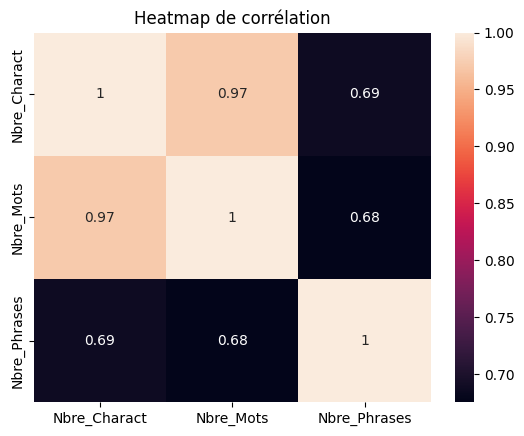

In [60]:
# Matrice de corrélation

# Sélection des variables numériques
num_vars = ['Nbre_Charact', 'Nbre_Mots', 'Nbre_Phrases']
df_num = data[num_vars]

# Génération de la heatmap de corrélation
sns.heatmap(df_num.corr(), annot=True)
plt.title('Heatmap de corrélation')
plt.show()

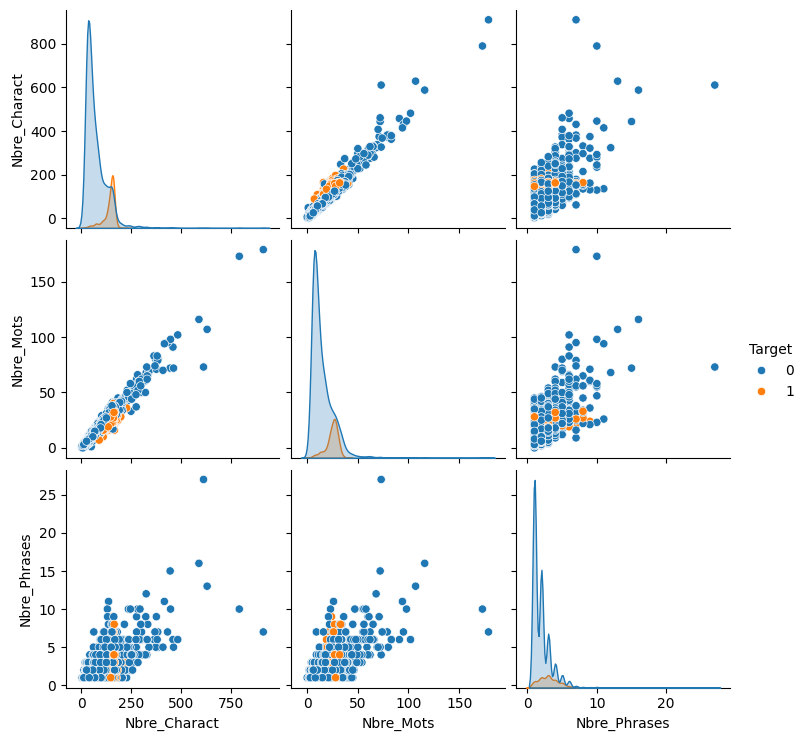

In [61]:
# A revoir !!!
sns.pairplot(data,hue='Target')

# Prétraitement et Transformation du texte avec la bibliothèque NLTK

In [62]:
import nltk
nltk.download('punkt')  # Télécharge la ressource de tokenisation
nltk.download('punkt_tab')
nltk.download('stopwords')

from nltk.corpus import stopwords
import string
from nltk.stem.porter import PorterStemmer

# Initialisation du stemmer
ps = PorterStemmer()

def transform_text(text):
    """
    Cette fonction applique plusieurs étapes de prétraitement sur le texte fourni :
    - conversion en minuscules
    - tokenisation (division du texte en mots)
    - suppression des mots non-alphanumériques (émojis, @, $, ...)
    - filtrage des mots vides (stopwords) et de la ponctuation 
    - stemming des mots restants

    Args:
    - text (str) : Le texte à transformer.

    Returns:
    - str : Le texte transformé après le prétraitement.
    """
    
    # 1. Conversion du texte en minuscules
    text = text.lower()
    
    # 2. Tokenisation du texte en mots individuels
    text = nltk.word_tokenize(text)
    
    # Liste temporaire pour stocker les mots valides (alphanumériques uniquement)
    y = []
    
    # 3. Suppression des mots non alphanumériques
    for i in text:
        if i.isalnum():
            y.append(i)
    
    # Mise à jour du texte après suppression des éléments non alphanumériques
    text = y[:]
    y.clear()  # Réinitialisation de la liste temporaire
    
    # 4. Suppression des stopwords et de la ponctuation
    for i in text:
        if i not in stopwords.words('english') and i not in string.punctuation:
            y.append(i)
    
    # Mise à jour du texte après suppression des stopwords et de la ponctuation
    text = y[:]
    y.clear()  # Réinitialisation de la liste temporaire
    
    # 5. Application du stemming
    for i in text:
        y.append(ps.stem(i))
    
    # 6. Retourner le texte transformé sous forme de chaîne
    return " ".join(y)


[nltk_data] Downloading package punkt to C:\Users\hp ProBook 450
[nltk_data]     G8\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to C:\Users\hp ProBook 450
[nltk_data]     G8\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\hp ProBook 450
[nltk_data]     G8\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [63]:
transform_text("La formation ISE à l'ENEAM est une formation d'excellence. L'ENEAM a intégré le Réseau en 2020.")

'la format ise à est une format intégré le réseau en 2020'

In [64]:
# Création d'une nouvelle variable 'Text_transform'
data['transformed_text'] = data['Text'].apply(transform_text)
data.head()

,Target,Text,Nbre_Charact,Nbre_Mots,Nbre_Phrases,transformed_text
0,0,"Go until jurong point, crazy.. Available only ...",111,20,3,go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,29,6,2,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,30,2,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,49,11,2,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,14,1,nah think goe usf live around though


# Nuage de mots pour les messages SPAM et HAM

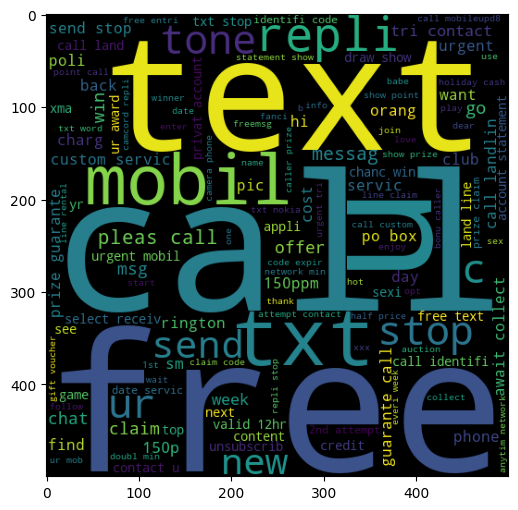

In [65]:
from wordcloud import WordCloud

# Création d'un objet WordCloud avec des paramètres de personnalisation pour l'apparence du nuage de mots
wc = WordCloud(
    width=500,              # Largeur de l'image du nuage de mots en pixels
    height=500,             # Hauteur de l'image du nuage de mots en pixels
    min_font_size=10,       # Taille minimale de la police pour les mots dans le nuage
    background_color='black'  # Couleur de fond du nuage de mots (noir dans ce cas)
)

# Génération du nuage de mots pour les messages de spam (target == 1)
# On sélectionne les textes transformés des messages de spam, puis on les concatène en une seule chaîne de texte
spam_wc = wc.generate(
    data[data['Target'] == 1]    # Filtre les messages dont la cible est égale à 1 (spam)
    ['transformed_text']     # Sélectionne la colonne contenant les textes transformés
    .str.cat(sep=" ")        # Combine tous les textes en une seule chaîne séparée par des espaces
)

# Création de la figure pour afficher le nuage de mots avec une taille spécifique
plt.figure(figsize=(15, 6))  # Spécifie la taille de la figure (15 pouces de large et 6 pouces de haut)

# Affichage du nuage de mots généré
plt.imshow(spam_wc)  

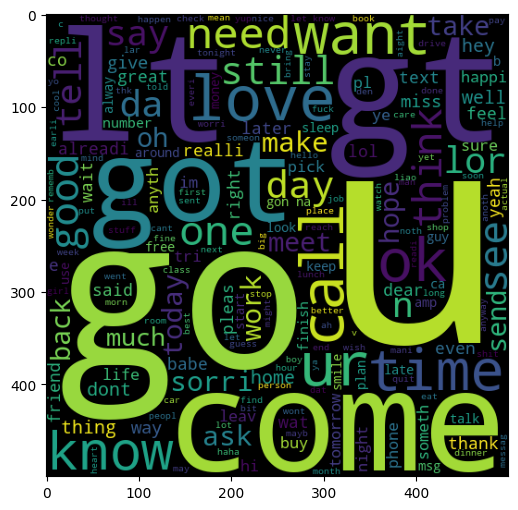

In [66]:
ham_wc = wc.generate(data[data['Target'] == 0]['transformed_text'].str.cat(sep=" "))
plt.figure(figsize=(15,6))
plt.imshow(ham_wc)

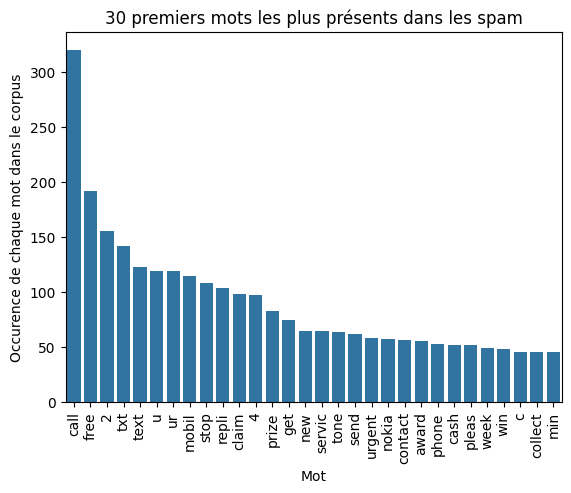

In [67]:
spam_corpus = []
for msg in data[data['Target'] == 1]['transformed_text'].tolist():
    for word in msg.split():
        spam_corpus.append(word)

from collections import Counter
# Création du DataFrame avec les 30 mots les plus fréquents
word_counts = pd.DataFrame(Counter(spam_corpus).most_common(30), columns=['Word', 'Frequency'])

# Création du graphique
sns.barplot(x=word_counts['Word'], y=word_counts['Frequency'])

# Rotation des labels de l'axe x
plt.xticks(rotation='vertical')

# Labélisation des axes
plt.xlabel('Mot')
plt.ylabel('Occurence de chaque mot dans le corpus')

# Affichage du graphique
plt.title('30 premiers mots les plus présents dans les spam')
plt.show()

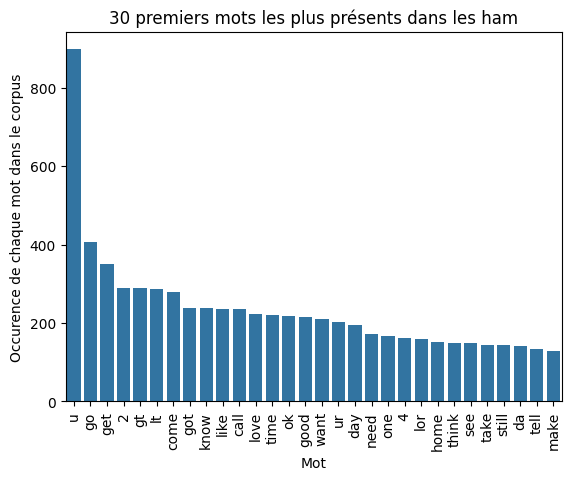

In [68]:
ham_corpus = []
for msg in data[data['Target'] == 0]['transformed_text'].tolist():
    for word in msg.split():
        ham_corpus.append(word)

from collections import Counter
# Création du DataFrame avec les 30 mots les plus fréquents
word_counts = pd.DataFrame(Counter(ham_corpus).most_common(30), columns=['Word', 'Frequency'])

# Création du graphique
sns.barplot(x=word_counts['Word'], y=word_counts['Frequency'])

# Rotation des labels de l'axe x
plt.xticks(rotation='vertical')

# Labélisation des axes
plt.xlabel('Mot')
plt.ylabel('Occurence de chaque mot dans le corpus')

# Affichage du graphique
plt.title('30 premiers mots les plus présents dans les ham')
plt.show()

# VECTORISATION DU TEXTE AVEC TF-IDF

In [69]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
cv = CountVectorizer()
tfidf = TfidfVectorizer(max_features=3000)
X = tfidf.fit_transform(data['transformed_text']).toarray()

In [70]:
Y = data['Target'].values

# SPLIT DU DATASET

In [71]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.3,random_state=2)

# CONSTRUCTION DES MODELES

In [72]:
from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score

In [73]:
gnb = GaussianNB()
mnb = MultinomialNB()
bnb = BernoulliNB()
lrc = LogisticRegression(solver='liblinear', penalty='l1')
svc = SVC(kernel='sigmoid', gamma=1.0)
knc = KNeighborsClassifier()
dtc = DecisionTreeClassifier(max_depth=5)
rfc = RandomForestClassifier(n_estimators=50, random_state=2)

In [74]:
clfs = {
    'GaussianNB' : gnb,
    'MultinomialNB' : mnb,
    'BernoulliNB' : bnb,
    'Logistic Regression' : lrc,
    'SVC' : svc,
    'Decision Tree': dtc,
    'Random Forest': rfc
}

In [75]:
# Fonction d'entraînement et d'évaluation du classificateur
def train_classifier(clf, X_train, Y_train, X_test, Y_test):
    # Entraîner le modèle
    clf.fit(X_train, Y_train)
    
    # Prédictions sur l'ensemble de test
    Y_pred = clf.predict(X_test)
    
    # Calcul des scores
    f1_current = f1_score(Y_test, Y_pred)  
    auc = roc_auc_score(Y_test, Y_pred)
    
    return f1_current, auc

In [76]:
# Listes pour stocker les résultats

f1_scores = [] 
auc = []
names = []  # Liste pour les noms des classificateurs

# Boucle sur les classificateurs
for name, clf in clfs.items():
    
    # Entraînement et évaluation du classificateur
    current_f1, auc_score = train_classifier(clf, X_train, Y_train, X_test, Y_test)
    
    # Ajouter les résultats à leurs listes respectives
    f1_scores.append(current_f1)  
    auc.append(auc_score)
    names.append(name)  

# Créer un DataFrame avec les résultats
results_df = pd.DataFrame({
    'Classifier': names,
    'F1 Score': f1_scores, 
    'AUC' : auc
})

# Afficher le DataFrame des résultats
print(results_df)

            Classifier  F1 Score       AUC
0           GaussianNB  0.627451  0.841225
1        MultinomialNB  0.835735  0.858911
2          BernoulliNB  0.888283  0.902725
3  Logistic Regression  0.732143  0.800381
4                  SVC  0.862637  0.886762
5        Decision Tree  0.640000  0.750389
6        Random Forest  0.853933  0.875497


In [77]:
bnb.fit(X_train, Y_train)

BernoulliNB()

In [78]:
predictions = bnb.predict(X_test)

# Afficher les résultats de la prédiction
print("\nPrédictions (1 = Spam, 0 = Ham) :")
print(predictions)


Prédictions (1 = Spam, 0 = Ham) :
[0 0 0 ... 1 0 1]


# TEST DU FILTRAGE ANTI-SPAM CREER

In [79]:
# Test de prédiction avec un nouveau message
new_message = "IMPORTANT: We've Been Trying to Contact You Many Times... PLEASE CONFIRM RECEIPT CONGRATULATIONS Goldenlion Casino Last chance to get your balance!"
transformed_message = transform_text(new_message)
vectorized_message = tfidf.transform([transformed_message]).toarray()

# Prédire si le message est spam ou non
new_prediction = bnb.predict(vectorized_message)
print("\nPrédiction pour le nouveau message :")
print(f"Le message est {'spam' if new_prediction[0] == 1 else 'ham'}")


Prédiction pour le nouveau message :
Le message est spam


# EVALUATION DU MODELE (Pour vérifier si nous sommes en présence d'overfitting et d'underfitting)

In [80]:
from sklearn.metrics import f1_score, roc_auc_score

# Fonction d'entraînement et d'évaluation du classificateur
def train_classifier(clf, X_train, Y_train, X_test, Y_test):
    # Entraîner le modèle
    clf.fit(X_train, Y_train)
    
    # Prédictions sur l'ensemble d'entraînement
    Y_train_pred = clf.predict(X_train)
    
    # Prédictions sur l'ensemble de test
    Y_test_pred = clf.predict(X_test)
    
    # Calcul des scores pour l'ensemble d'entraînement
    f1_train = f1_score(Y_train, Y_train_pred)  
    auc_train = roc_auc_score(Y_train, Y_train_pred)
    
    # Calcul des scores pour l'ensemble de test
    f1_test = f1_score(Y_test, Y_test_pred)
    auc_test = roc_auc_score(Y_test, Y_test_pred)
    
    return (f1_train, auc_train), (f1_test, auc_test)


In [81]:
# Listes pour stocker les résultats
f1_train_scores = [] 
auc_train_scores = [] 
f1_test_scores = [] 
auc_test_scores = [] 
names = []  # Liste pour les noms des classificateurs

# Boucle sur les classificateurs
for name, clf in clfs.items():
    
    # Entraînement et évaluation du classificateur
    (f1_train, auc_train), (f1_test, auc_test) = train_classifier(clf, X_train, Y_train, X_test, Y_test)
    
    # Ajouter les résultats à leurs listes respectives
    f1_train_scores.append(f1_train)  
    auc_train_scores.append(auc_train)
    f1_test_scores.append(f1_test)
    auc_test_scores.append(auc_test)
    names.append(name)

# Créer un DataFrame avec les résultats
results_df = pd.DataFrame({
    'Classifier': names,
    'F1 Train': f1_train_scores, 
    'AUC Train': auc_train_scores,
    'F1 Test': f1_test_scores,
    'AUC Test': auc_test_scores
})

# Afficher le DataFrame des résultats
print(results_df)

            Classifier  F1 Train  AUC Train   F1 Test  AUC Test
0           GaussianNB  0.728595   0.946970  0.627451  0.841225
1        MultinomialNB  0.904010   0.912417  0.835735  0.858911
2          BernoulliNB  0.938012   0.944094  0.888283  0.902725
3  Logistic Regression  0.839752   0.872198  0.732143  0.800381
4                  SVC  0.936563   0.948533  0.862637  0.886762
5        Decision Tree  0.767471   0.829445  0.654434  0.758185
6        Random Forest  0.996663   0.996674  0.853933  0.875497


# PREPARATION POUR L'INTERFACE

In [82]:
import pickle 
pickle.dump(tfidf,open('vectorizer.pkl','wb'))
pickle.dump(bnb,open('model.pkl','wb'))